<a href="https://colab.research.google.com/github/rediahmds/eco-sort/blob/main/train/train_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect to Google Drive

In [14]:
USE_CLEARML = False
USE_GOOGLE_COLAB = False

In [2]:
if USE_GOOGLE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
else:
    !pip install PyDrive2

    from pydrive2.auth import GoogleAuth
    from pydrive2.drive import GoogleDrive

    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    GCP_CLIENT_SECRET = user_secrets.get_secret("GCP_CLIENT_SECRET")

    with open("client_secrets.json", "w") as f:
        f.write(GCP_CLIENT_SECRET)


    gauth = GoogleAuth()
    gauth.CommandLineAuth()

    drive = GoogleDrive(gauth)

    def save_to_gdrive(name: str, destination_dir_id: str):
        pass

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=991309652978-hpmqspbdt0bccglf6iklc3er1d9naa8q.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=online&response_type=code



Enter verification code:  4/1AVMBsJgC73mrKqFVsFAiZZhT0GeIR5GP05WJmNcvWhFaBr7QJG1d1CWyl3U


Authentication successful.


## Prepare dataset (Run only once)

Run for the first time only. when starting new session, dont run it.

### Download

In [3]:
import shutil
import os

def copy_file_to_folder(source_path: str, destination_folder: str, preserve_metadata: bool = False):
    """
    Copies a file to a specified folder, creating the folder if it doesn't exist.

    Args:
        source_path (str): The full path to the source file.
        destination_folder (str): The path to the destination folder.
        preserve_metadata (bool): If True, preserves file metadata (uses shutil.copy2).
                                  Defaults to False.

    Returns:
        bool: True if the copy was successful, False otherwise.
    """
    try:
        # Create the destination folder if it doesn't exist
        os.makedirs(destination_folder, exist_ok=True)

        # Choose the copy function based on the preserve_metadata flag
        if preserve_metadata:
            shutil.copy2(source_path, destination_folder)
        else:
            shutil.copy(source_path, destination_folder)

        print(f"File '{source_path}' copied successfully to '{destination_folder}'. ✅")

        return True

    except FileNotFoundError:
        print(f"Error: The source file was not found at '{source_path}'.")
        return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [5]:
if USE_GOOGLE_COLAB:
    DATASET_PATH = "/content/drive/MyDrive/Cool Lee Yeah/8th Semester/Skripsi/Datasets/dataset_no-styro.7z"
    copy_file_to_folder(DATASET_PATH, "/content/")
else:
    GDRIVE_DATASET_FILE_ID = user_secrets.get_secret("GDRIVE_DATASET_FILE_ID")
    file_id = GDRIVE_DATASET_FILE_ID
    local_filename = "dataset.7z" # save as

    try:
        file_to_download = drive.CreateFile({'id': file_id})

        print(f"⬇️ Downloading file: '{file_to_download['title']}'...")
        file_to_download.GetContentFile(local_filename)

        print(f"✅ Downloaded successfully and saved as '{local_filename}'")

    except Exception as e:
        print(f"Error: {e}")

⬇️ Downloading file: 'dataset_no-styro.7z'...
✅ Downloaded successfully and saved as 'dataset.7z'


### Extract the Dataset

In [8]:
!7z x dataset.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Sca        1 file, 1234923334 bytes (1178 MiB)

Extracting archive: dataset.7z
--
Path = dataset.7z
Type = 7z
Physical Size = 1234923334
Headers Size = 178477
Method = LZMA2:24
Solid = +
Blocks = 1

      0% 9 - dataset/train/background/0.jp                                        0% 582 - dataset/train/background/158.jp                                            0% 828 - dataset/train/background/38.j                                          0% 1211 - dataset/train/background/724.j                                            0% 1363 - dataset/train/background/861.j                                            1% 1532 - dataset/train/glass/Glass_113.jp                                              1% 1608 - dataset/train/glass/Glass_182.jp                     

Show directory tree

### Create Validation Dataset

This dataset will be created by moving some files from training dataset.

In [9]:
from pathlib import Path
import random
from tqdm import tqdm
import shutil

import os

def count_files_in_folders(base_path):
  """
  Counts the number of files in each subfolder of a given path.

  Args:
    base_path (str): The path to the parent directory (e.g., 'dataset/train').

  Returns:
    dict: A dictionary with subfolder names as keys and file counts as values.
          Returns None if the path is not found.
  """
  if not os.path.isdir(base_path):
    print(f"Error: Directory not found at '{base_path}'")
    return None

  counts_per_class = {}
  # Loop through each item in the base directory
  for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    # Ensure it is a directory
    if os.path.isdir(class_path):
      # Count the number of files inside the subdirectory and store it
      file_count = len(os.listdir(class_path))
      counts_per_class[class_name] = file_count
  return counts_per_class

def calculate_dataset_split(counts_per_class, percentage):
  """
  Calculates the number of items per class for a split based on a percentage.
  """
  if not 0 <= percentage <= 100:
    raise ValueError("Percentage must be between 0 and 100.")

  split_counts_result = {}
  for class_name, total_count in counts_per_class.items():
    split_count = total_count * (percentage / 100)
    # Round to the nearest integer as file counts cannot be fractional
    split_counts_result[class_name] = round(split_count)
  return split_counts_result

def move_validation_split_custom(train_dir, val_dir, per_class_counts: dict, random_select=True):
    train_dir = Path(train_dir)
    val_dir = Path(val_dir)
    val_dir.mkdir(parents=True, exist_ok=True)

    for class_name, n in per_class_counts.items():
        class_dir = train_dir / class_name
        if not class_dir.exists():
            print(f"⚠️ Folder tidak ditemukan: {class_dir}")
            continue

        images = sorted([p for p in class_dir.glob("*.*") if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}])
        selected = random.sample(images, min(n, len(images))) if random_select else images[:n]
        val_class_dir = val_dir / class_name
        val_class_dir.mkdir(parents=True, exist_ok=True)

        print(f"📁 {class_name}: Memindahkan {len(selected)} file...")
        for img in tqdm(selected, desc=f"  Pindah {class_name}", leave=False):
            shutil.move(str(img), str(val_class_dir / img.name))

    print("\n✅ Selesai membuat validasi set proporsional.")


### Divide Dataset

There are two methods for this, `StratifiedShuffle` and `train_test_split`

In [6]:
from torchvision import datasets

DATASET_PATH = "dataset/train"
full_dataset = datasets.ImageFolder(DATASET_PATH)
class_names = full_dataset.classes

#### (1) Divide: Stratified Method

In [ ]:
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
import shutil
from tqdm import tqdm

def stratified_split_imagefolder(source_dir: Path | str,
                                  target_train: Path | str,
                                  target_val: Path | str,
                                  val_ratio=0.2,
                                  random_state=42):
    source_dir = Path(source_dir)
    target_train = Path(target_train)
    target_val = Path(target_val)
    target_train.mkdir(parents=True, exist_ok=True)
    target_val.mkdir(parents=True, exist_ok=True)

    transform = transforms.Compose([transforms.ToTensor()])
    dataset = ImageFolder(str(source_dir), transform=transform)

    paths = [Path(p) for p, _ in dataset.samples]
    labels = [label for _, label in dataset.samples]
    class_names = dataset.classes

    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=random_state)
    train_idx, val_idx = next(sss.split(paths, labels))

    print(f"📦 Total gambar: {len(paths)}")
    print(f"✅ Train: {len(train_idx)}")
    print(f"✅ Val  : {len(val_idx)}")

    def copy_split(index_list, target_root):
        for idx in tqdm(index_list, desc=f"Salin ke {target_root.name}"):
            src = paths[idx]
            label_name = class_names[labels[idx]]
            dest_dir = target_root / label_name
            dest_dir.mkdir(parents=True, exist_ok=True)
            shutil.copy(src, dest_dir / src.name)

    copy_split(train_idx, target_train)
    copy_split(val_idx, target_val)

    print("✅ Stratified split selesai.")


In [ ]:
stratified_split_imagefolder(
    source_dir="dataset/train",
    target_train="dataset_stratified/train",
    target_val="dataset_stratified/test",
    val_ratio=0.2,
    random_state=42
)

📦 Total gambar: 22198
✅ Train: 17758
✅ Val  : 4440


Salin ke test: 100%|██████████| 4440/4440 [00:01<00:00, 2892.72it/s]

✅ Stratified split selesai.


#### (2) Divide: train_test_split

In [23]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from collections import Counter




# 🔁 Transformasi
# Augmentasi
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomGrayscale(p=0.1),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
# Transformasi untuk validasi/test tanpa augmentasi acak
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

targets = full_dataset.targets
train_idx, val_idx = train_test_split(
    np.arange(len(targets)),      # Buat array dari index 0 sampai N-1
    test_size=0.2,                # Alokasikan 20% untuk validasi
    shuffle=True,
    stratify=targets              # INI KUNCINYA: pastikan proporsi kelas sama
)

train_labels = [targets[i] for i in train_idx]
print(f"Distribusi kelas di Training: {Counter(train_labels)}")
class_counts = Counter(train_labels)
num_samples = len(train_labels)
class_weights = {
    class_id: num_samples / count for class_id, count in class_counts.items()
}
weights = [class_weights[label] for label in train_labels]
sampler = torch.utils.data.WeightedRandomSampler(
    weights=torch.DoubleTensor(weights),
    num_samples=num_samples
)

val_labels = [targets[i] for i in val_idx]
print(f"Distribusi kelas di Validasi: {Counter(val_labels)}")

train_dataset = Subset(full_dataset, train_idx)
train_dataset.dataset.transform = train_transform

val_dataset = Subset(full_dataset, val_idx)
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Total data: {len(full_dataset)} gambar")
print(f"Data Training: {len(train_dataset)} gambar")
print(f"Data Validasi: {len(val_dataset)} gambar")
print(f"Nama Kelas: {class_names}")

Distribusi kelas di Training: Counter({4: 3233, 6: 3114, 5: 2611, 3: 2568, 1: 2487, 2: 2122, 0: 1206})
Distribusi kelas di Validasi: Counter({4: 809, 6: 778, 5: 653, 3: 642, 1: 622, 2: 531, 0: 301})
Total data: 21677 gambar
Data Training: 17341 gambar
Data Validasi: 4336 gambar
Nama Kelas: ['background', 'glass', 'metal', 'organic', 'paper', 'plastic', 'textiles']


### Data Distribution checking

## Training and Evaluation

#### Setup ClearML

Go ahead and sign-up/sign-in to [AI Infrastructure Platform | Maximize AI Performance & Scalability | ClearML](https://clear.ml/)

After that, go to Settings -> Workspace -> Create new credentials

The new credentials will be created and shows two options:

Local Python (Recommended)
Jupyter Notebook
Both actually are the same things, it only differs on how to use the new credentials.

This time, use the clearml CLI app to consume the credentials, when prompted, paste it.

In [13]:
!pip install clearml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.1 MB/s eta 0:00:0000:01


In [ ]:
CLEARML_CONF = user_secrets.get_secret("CLEARML_CONF")


with open("/root/clearml.conf", "w") as f:
    f.write(CLEARML_CONF)

In [ ]:
!clearml-init

ClearML SDK setup process

Please create new clearml credentials through the settings page in your `clearml-server` web app (e.g. http://localhost:8080//settings/workspace-configuration) 
Or create a free account at https://app.clear.ml/settings/workspace-configuration

In settings page, press "Create new credentials", then press "Copy to clipboard".

Paste copied configuration here:
api {   # Redi Ahmad Supriyatna's workspace   web_server: https://app.clear.ml/   api_server: https://api.clear.ml   files_server: https://files.clear.ml   credentials {     "access_key" = "XP018Y5KX0LBYJ9JY0LSA1F8BRATNJ"     "secret_key" = "Tt_arUNOmgaL3_VIsCUmPAHXGYRpY70dKLnyh7Vln6Ew5eRUHdeeU8ODfiEHoRd0kT8"   } }
Detected credentials key="XP018Y5KX0LBYJ9JY0LSA1F8BRATNJ" secret="Tt_a***"

ClearML Hosts configuration:
Web App: https://app.clear.ml/
API: https://api.clear.ml
File Store: https://files.clear.ml

Verifying credentials ...
Credentials verified!

New configuration stored in /root/clearml.conf
Cl

In [14]:
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [ ]:
#@title <b>Time Out Preventer (Advanced) </b></strong>
%%capture
AUTO_RECONNECT = True #@param {type:"boolean"}
#@markdown **Run this code to prevent Google Colab from Timeout**
from os import makedirs
makedirs("/root/.config/rclone", exist_ok = True)
if AUTO_RECONNECT:
  import IPython
  from google.colab import output

  display(IPython.display.Javascript('''
  function ClickConnect(){
    btn = document.querySelector("colab-connect-button")
    if (btn != null){
      console.log("Click colab-connect-button");
      btn.click()
      }

    btn = document.getElementById('ok')
    if (btn != null){
      console.log("Click reconnect");
      btn.click()
      }
    }

  setInterval(ClickConnect,60000)
  '''))

In [ ]:
while True:
    pass

KeyboardInterrupt: 

### Training Options (Choose one of these)

####  Choose Base Model

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models

def create_model(model_name: str, num_classes: int, feature_extract: bool = True):
    """
    Memuat pre-trained model dari torchvision menggunakan pendekatan hardcode yang andal
    dan menyesuaikannya untuk transfer learning. ✅

    Args:
        model_name (str): Nama model yang didukung (contoh: 'resnet50', 'mobilenet_v3_small').
        num_classes (int): Jumlah kelas output untuk dataset baru.
        feature_extract (bool): Jika True, bekukan bobot kecuali layer terakhir.
                              Jika False, seluruh model akan dilatih (fine-tuning).

    Returns:
        torch.nn.Module: Model yang sudah disesuaikan dan siap pakai.
    """

    # --- Langkah 1: Tentukan model yang didukung secara eksplisit ---
    # Pendekatan ini lebih aman dan mencegah error akibat penamaan yang tidak konsisten.
    supported_models = {
        # ResNet Family
        "resnet18": (models.resnet18, models.ResNet18_Weights.DEFAULT),
        "resnet50": (models.resnet50, models.ResNet50_Weights.DEFAULT),
        # MobileNet Family
        "mobilenet_v2": (models.mobilenet_v2, models.MobileNet_V2_Weights.DEFAULT),
        "mobilenet_v3_small": (models.mobilenet_v3_small, models.MobileNet_V3_Small_Weights.DEFAULT),
        "mobilenet_v3_large": (models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT),
        # EfficientNet Family
        "efficientnet_b0": (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT),
        "efficientnet_b7": (models.efficientnet_b7, models.EfficientNet_B7_Weights.DEFAULT),
        # Other Architectures
        "vgg16": (models.vgg16, models.VGG16_Weights.DEFAULT),
        "densenet121": (models.densenet121, models.DenseNet121_Weights.DEFAULT),
        "vit_b_16": (models.vit_b_16, models.ViT_B_16_Weights.DEFAULT),
        "swin_t": (models.swin_t, models.Swin_T_Weights.DEFAULT),
    }

    if model_name not in supported_models:
        raise ValueError(
            f"Model '{model_name}' tidak didukung.\n"
            f"Model yang tersedia: {list(supported_models.keys())}"
        )

    # Ambil constructor dan bobot dari dictionary
    model_constructor, weights = supported_models[model_name]

    # Buat instance model dengan bobot pre-trained
    model = model_constructor(weights=weights)

    # --- Langkah 2: Membekukan Bobot (jika feature_extract=True) ---
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

    # --- Langkah 3: Mengganti Layer Klasifikasi Terakhir ---
    # Logika ini tetap sama karena sudah cukup robust
    if hasattr(model, 'fc'): # Untuk ResNet, dll.
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, nn.Sequential): # Untuk VGG, MobileNet, EfficientNet
            last_layer = model.classifier[-1]
            if isinstance(last_layer, nn.Linear):
                num_ftrs = last_layer.in_features
                model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
            else:
                raise TypeError(f"Layer terakhir dari classifier ({type(last_layer)}) bukan nn.Linear.")
        elif isinstance(model.classifier, nn.Linear): # Untuk DenseNet
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, num_classes)
        else:
            raise TypeError(f"Tipe classifier ({type(model.classifier)}) tidak didukung.")

    elif hasattr(model, 'head'): # Untuk Vision Transformer, Swin Transformer
        num_ftrs = model.head.in_features
        model.head = nn.Linear(num_ftrs, num_classes)

    else:
        raise NameError(f"Layer klasifikasi untuk '{model_name}' tidak ditemukan.")

    return (model_name, model)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """
    Fungsi untuk menampilkan grafik loss dan akurasi training & validation.
    """
    # Buat 2 subplot berdampingan
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    epochs_range = range(1, len(train_losses) + 1)

    # Plot 1: Model Loss
    ax1.plot(epochs_range, train_losses, 'o-', color='tab:blue', label='Training Loss')
    ax1.plot(epochs_range, val_losses, 'o-', color='tab:orange', label='Validation Loss')
    ax1.set_title('Model Loss', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plot 2: Model Accuracy
    ax2.plot(epochs_range, train_accs, 'o-', color='tab:green', label='Training Accuracy')
    ax2.plot(epochs_range, val_accs, 'o-', color='tab:red', label='Validation Accuracy')
    ax2.set_title('Model Accuracy', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(loc='lower right')
    ax2.grid(True)
    
    plt.suptitle('Visualisasi Metrik Pelatihan', fontsize=20, y=1.02)
    plt.tight_layout()
    

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Fungsi untuk menampilkan confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                          xticklabels=class_names, yticklabels=class_names)
    heatmap.set_xlabel('Kelas Prediksi', fontsize=12, labelpad=10)
    heatmap.set_ylabel('Kelas Aktual', fontsize=12, labelpad=10)
    heatmap.set_title('Confusion Matrix Final', fontsize=16, pad=20)

#### (1) Training with early stopping - Recommended

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🔁 Epoch 1/32
  → Train Acc: 0.7650 | Val Acc: 0.8416
  → Train Loss: 0.7196 | Val Loss: 0.4800
🏆 Model terbaik disimpan ke Models/resnet50_best_model.pt
⏱️ Waktu epoch: 76.99 detik

🔁 Epoch 2/32
  → Train Acc: 0.8343 | Val Acc: 0.8515
  → Train Loss: 0.4963 | Val Loss: 0.4461
🏆 Model terbaik disimpan ke Models/resnet50_best_model.pt
⏱️ Waktu epoch: 76.42 detik

🔁 Epoch 3/32
  → Train Acc: 0.8474 | Val Acc: 0.8607
  → Train Loss: 0.4457 | Val Loss: 0.4243
🏆 Model terbaik disimpan ke Models/resnet50_best_model.pt
⏱️ Waktu epoch: 76.76 detik

🔁 Epoch 4/32
  → Train Acc: 0.8597 | Val Acc: 0.8644
  → Train Loss: 0.4114 | Val Loss: 0.4035
🏆 Model terbaik disimpan ke Models/resnet50_best_model.pt
⏱️ Waktu epoch: 76.71 detik

🔁 Epoch 5/32
  → Train Acc: 0.8689 | Val Acc: 0.8649
  → Train Loss: 0.3888 | Val Loss: 0.4183
🏆 Model terbaik disimpan ke Models/resnet50_best_model.pt
⏱️ Waktu epoch: 76.61 detik

🔁 Epoch 6/32
  → Train Acc: 0.8708 | Val Acc: 0.8565
  → Train Loss: 0.3794 | Val Loss: 0.

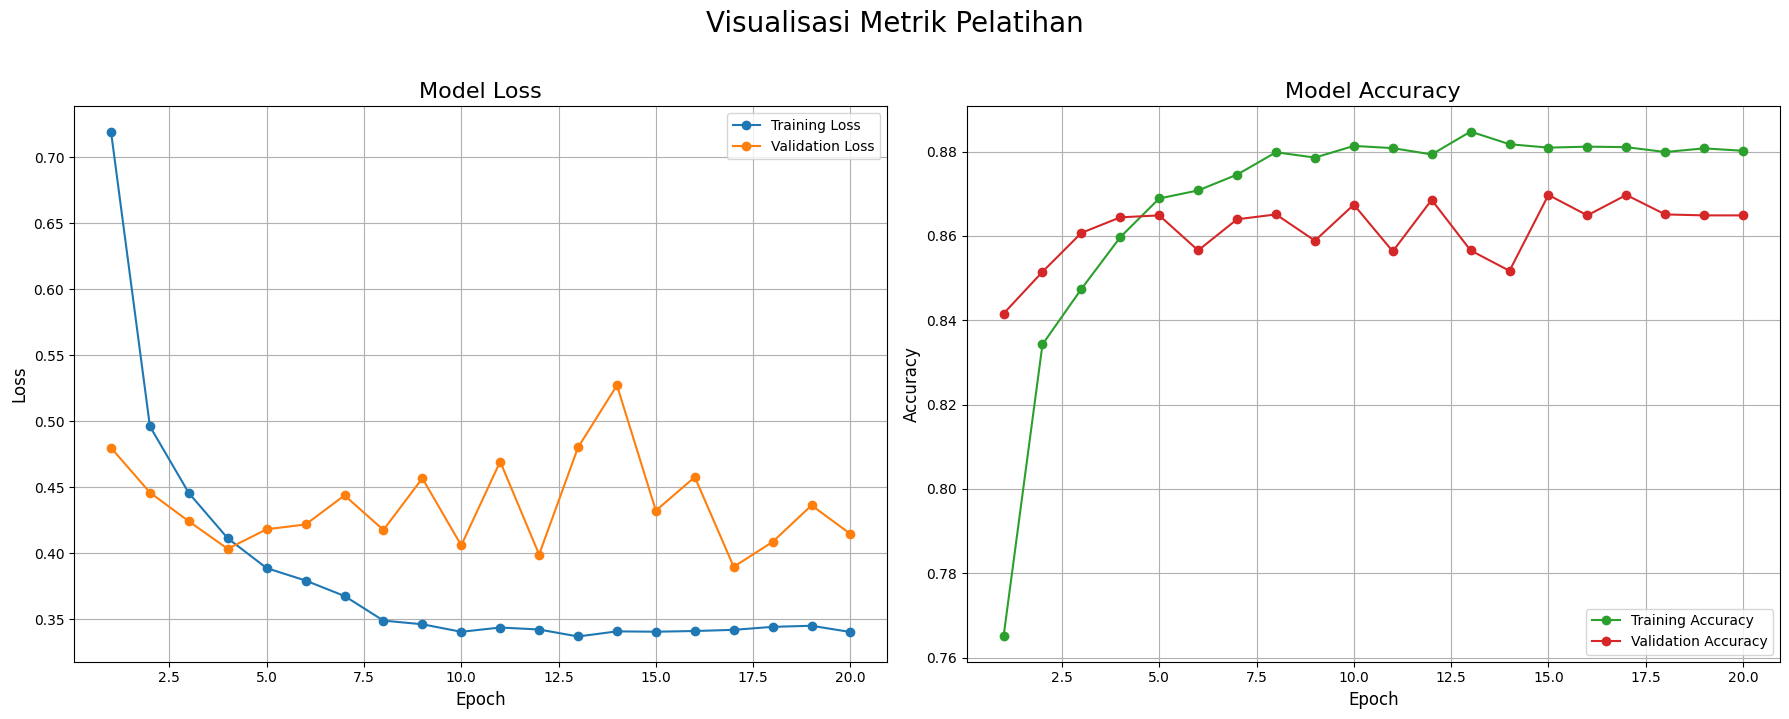

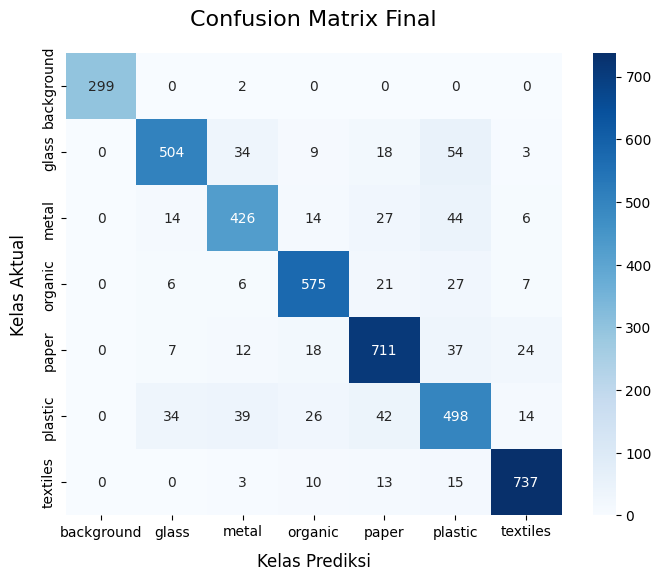

In [22]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import time
import os


# Impor ClearML hanya jika diperlukan
if USE_CLEARML:
    from clearml import Task, Logger

# ⚙️ Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name, model = create_model(model_name="resnet50", num_classes=len(class_names))
model = model.to(device)

# Penanganan Dataset Tidak Seimbang
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_names),
    y=class_names
)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Kurangi LR saat val_loss tidak membaik
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2, verbose=True)

# 🔁 Pengaturan Training Loop
epochs = 32
patience = 5
train_accs, val_accs = [], []
train_losses, val_losses = [], []
best_val_acc = 0
early_stop_counter = 0

# Penyimpanan Model
# if USE_GOOGLE_COLAB:
#     save_dir = "/content/drive/MyDrive/AI_Models"

save_dir = "Models"
os.makedirs(save_dir, exist_ok=True)
best_model_path = os.path.join(save_dir, f"{model_name}_best_model.pt")
latest_model_path = os.path.join(save_dir, f"{model_name}_latest_model.pt")

# Inisialisasi ClearML jika diaktifkan
if USE_CLEARML:
    task = Task.init(
        project_name="EcoSort CNN",
        task_name=f"{model_name} Training {time.strftime('%a, %b %-d, %Y - %H:%M:%S')}",
        task_type=Task.TaskTypes.training
    )
    logger = task.get_logger()

# 🔍 Fungsi logging yang lebih fleksibel
def log_matplotlib_figure(fig, title, series, epoch):
    if USE_CLEARML:
        logger.report_matplotlib_figure(title=title, series=series, figure=fig, iteration=epoch)
    plt.close(fig)

# 🏃 Training dimulai
try:
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)
        train_acc = correct / total
        train_loss_avg = train_loss / len(train_loader)
        train_accs.append(train_acc.item()); train_losses.append(train_loss_avg)

        if USE_CLEARML:
            logger.report_scalar("Accuracy", "Train", value=train_acc.item(), iteration=epoch)
            logger.report_scalar("Loss", "Train", value=train_loss_avg, iteration=epoch)
            logger.report_scalar("LR", "Learning Rate", value=optimizer.param_groups[0]['lr'], iteration=epoch)

        # 🔍 Validasi
        model.eval()
        val_loss, correct, total = 0, 0, 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels)
                total += labels.size(0)
                y_true.extend(labels.cpu().numpy()); y_pred.extend(preds.cpu().numpy())
        val_acc = correct / total
        val_loss_avg = val_loss / len(val_loader)
        val_accs.append(val_acc.item()); val_losses.append(val_loss_avg)
        scheduler.step(val_loss_avg)

        if USE_CLEARML:
            logger.report_scalar("Accuracy", "Validation", value=val_acc.item(), iteration=epoch)
            logger.report_scalar("Loss", "Validation", value=val_loss_avg, iteration=epoch)

            # Classification Report & Metrics
            report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
            for class_name, metrics in report.items():
                if isinstance(metrics, dict): # Hindari 'accuracy' yang bukan dict
                    logger.report_scalar(f"F1-Score/{class_name}", "Validation", value=metrics["f1-score"], iteration=epoch)

            # Confusion Matrix
            cm = confusion_matrix(y_true, y_pred)
            fig_cm, ax = plt.subplots(figsize=(8, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
            ax.set_title("Confusion Matrix")
            ax.set_xlabel("Predicted Label")
            ax.set_ylabel("True Label")
            log_matplotlib_figure(fig_cm, "Confusion Matrix", "Validation", epoch)

        print(f"🔁 Epoch {epoch+1}/{epochs}")
        print(f"  → Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        print(f"  → Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")


        # Simpan model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"🏆 Model terbaik disimpan ke {best_model_path}")
        else:
            early_stop_counter += 1
            torch.save(model.state_dict(), latest_model_path)
            print(f"📦 Model terbaru disimpan ke {latest_model_path}")
            if early_stop_counter >= patience:
                print("⏹️ Early stopping terpicu.")
                break

        duration = time.time() - start_time
        print(f"⏱️ Waktu epoch: {duration:.2f} detik")
        if USE_CLEARML:
            logger.report_scalar("Epoch Time (sec)", "Duration", value=duration, iteration=epoch)

        print()

finally:
    # 🎉 Selesai
    print("\n=== Laporan Klasifikasi Akhir ===")
    print(classification_report(y_true, y_pred, target_names=class_names))
    if USE_CLEARML and 'task' in locals():
        print("Menutup task ClearML.")
        task.close()

    if train_losses and val_losses and train_accs and val_accs:
        plot_training_history(train_losses, val_losses, train_accs, val_accs)
        plot_confusion_matrix(y_true, y_pred, class_names)
        plt.show()
    else:
        print("Tidak ada data histori training untuk diplot.")

#### (2) Training without early stopping

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import time

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Dataset
train_dataset = datasets.ImageFolder("dataset/train", transform=transform)
class_names = train_dataset.classes
print("Label mapping:", train_dataset.class_to_idx)
print("Distribusi:", Counter([label for _, label in train_dataset]))

val_dataset = datasets.ImageFolder("dataset/test", transform=transform)
print("Label mapping:", val_dataset.class_to_idx)
print("Distribusi:", Counter([label for _, label in val_dataset]))

# Split
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 6
train_accs, val_accs = [], []
best_val_acc = 0

for epoch in range(epochs):
    model.train()
    correct, total, loss_total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_total += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)

    train_acc = correct / total
    train_accs.append(train_acc.item())
    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}")

    # Validasi
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

    val_acc = correct / total
    val_accs.append(val_acc.item())
    print(f"            → Val Acc: {val_acc:.4f}")

# Simpan
torch.save(model.state_dict(), "model_cnn.pt")
print("✅ Model disimpan.")

### Evaluation

In [ ]:
# 📊 Evaluasi dengan laporan & Confusion Matrix
model.eval()
y_true, y_pred = [], []

for images, labels in val_loader:
    images = images.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds.cpu().numpy())

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Plot akurasi training & val
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()